In [1]:
import random
import torch
import numpy as np
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  
        
seed = 42
setup_seed(seed=seed)

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/anndata/compat/__init__.py:371: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


                            orig.ident  nCount_RNA  nFeature_RNA batch  \
exp1-TP1_AAACCCAGTATCCCTC-1   SCCRISPR     25191.0          4591  exp1   
exp1-TP1_AAACGAACAGGCCCTA-1   SCCRISPR     24236.0          4760  exp1   
exp1-TP1_AAACGAATCTCGGTCT-1   SCCRISPR      2190.0          1107  exp1   
exp1-TP1_AAACGCTCAAGGGCAT-1   SCCRISPR     14769.0          3784  exp1   
exp1-TP1_AAACGCTCATCGATAC-1   SCCRISPR     56108.0          6619  exp1   

                            timepoint   CRISPRguide CRISPRgene        BT  \
exp1-TP1_AAACCCAGTATCCCTC-1       TP1  Stat5b_gRNA5     Stat5b  exp1-TP1   
exp1-TP1_AAACGAACAGGCCCTA-1       TP1  Notch1_gRNA1     Notch1  exp1-TP1   
exp1-TP1_AAACGAATCTCGGTCT-1       TP1     Fos_gRNA4        Fos  exp1-TP1   
exp1-TP1_AAACGCTCAAGGGCAT-1       TP1     Jun_gRNA1        Jun  exp1-TP1   
exp1-TP1_AAACGCTCATCGATAC-1       TP1   Hoxa1_gRNA4      Hoxa1  exp1-TP1   

                             percent.mito   S.Score  G2M.Score Phase  \
exp1-TP1_AAACCCAGTATCCCTC-

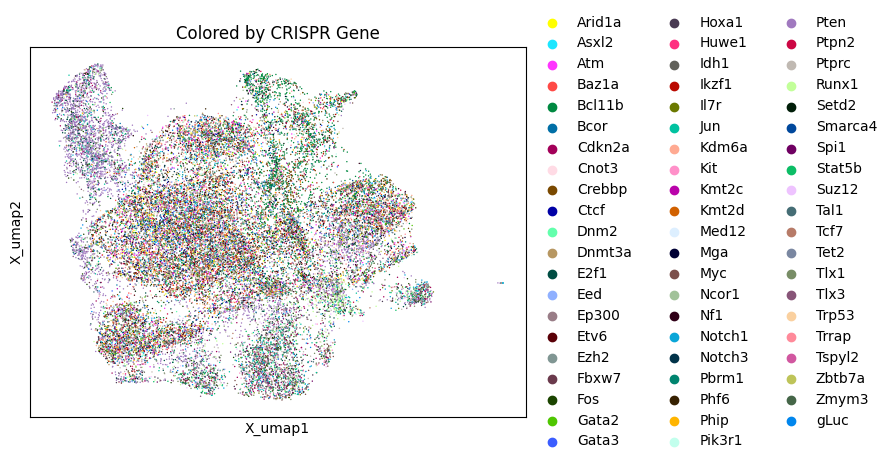

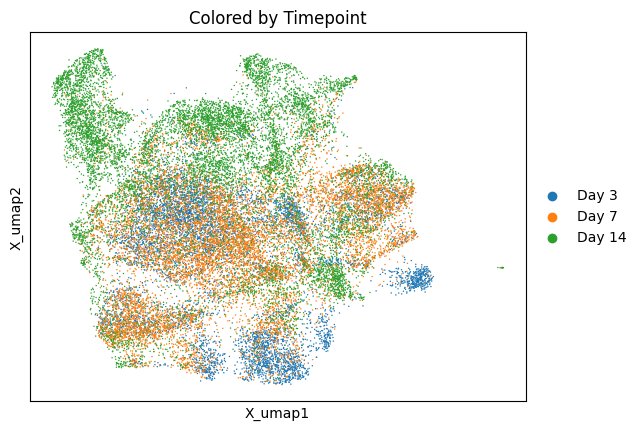

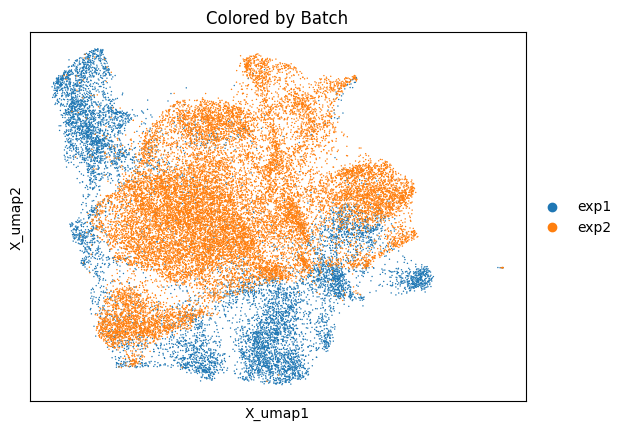

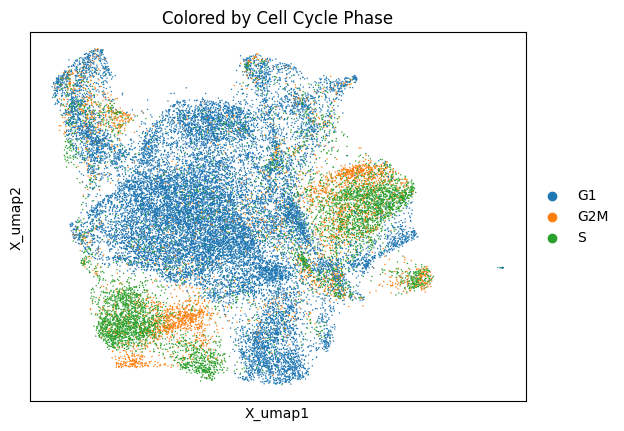

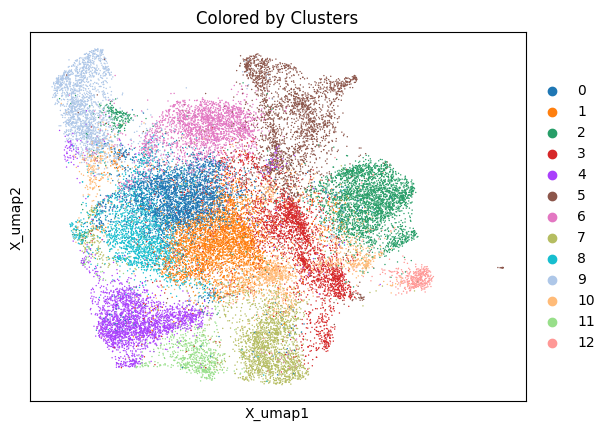

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap

# --- 1. 加载数据 ---
print("Loading data...") 

adata = sc.read_h5ad('Data/2.5/GSE222378_SCCRISPR-full-object.h5ad')

print(adata.obs.head(5))
print(adata.var)
print(adata.X)


adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category')


from sklearn.decomposition import PCA

pca_model = PCA(n_components=50, random_state=42)


pca_embedding = pca_model.fit_transform(adata.X)

adata.obsm['X_pca'] = pca_embedding


reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=2, n_jobs=1, random_state=seed)


data_contiguous = np.ascontiguousarray(adata.obsm['X_pca'])
data_contiguous = data_contiguous.astype(np.float32)
embedding = reducer.fit_transform(data_contiguous)

adata.obsm['X_umap'] = embedding


basis = 'X_umap'
point_dic = {'TP1':'Day 3','TP2':'Day 7','TP3':'Day 14'}
point_dic_inverse = {'Day 3':'TP1','Day 7':'TP2','Day 14':'TP3'}


sc.pl.embedding(adata, basis=basis, color='CRISPRgene', title='Colored by CRISPR Gene', save='raw_data_CRISPRgene_labeled')

adata.obs['timepoint'] = adata.obs['timepoint'].apply(lambda x: point_dic[x])

sc.pl.embedding(adata, basis=basis, color='timepoint', title='Colored by Timepoint', save='raw_data_timepoint_labeled')
adata.obs['timepoint'] = adata.obs['timepoint'].apply(lambda x: point_dic_inverse[x])


sc.pl.embedding(adata, basis=basis, color='batch', title='Colored by Batch', save='raw_data_batch_labeled')

sc.pl.embedding(adata, basis=basis, color='Phase', title='Colored by Cell Cycle Phase', save='raw_data_Phase_labeled')

sc.pl.embedding(adata, basis=basis, color='seurat_clusters', title='Colored by Clusters', save='raw_data_seurat_clusters_labeled')


In [3]:
import torch
import scope
from scope import model
from scope import computations as cmp
from scope import clustering as cl
from scope import pre_match as pm
from scope import visualizations as vi

data_lst = [torch.Tensor(adata[adata.obs[adata.obs['timepoint']==t].index,:].obsm['X_pca']).double() for t in adata.obs['timepoint'].unique()]
time_steps = [3,7,14]
meta=[[time_steps[i]]*len(data_lst[i]) for i in range(len(time_steps))]
meta=np.concatenate(meta)

In [4]:
cluster_centers, labels_list, best_k = cl.kmeans_auto([d.cuda() for d in data_lst],tol=1e-4,method='calinski_harabasz',max_k=10,least_Ks=5)
print(best_k)

max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences(data_lst)
print(max_variance_differences)
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.99,min_eps=0.5) 

[5, 5, 5]
[24.714207936401962, 325.88285088227383]


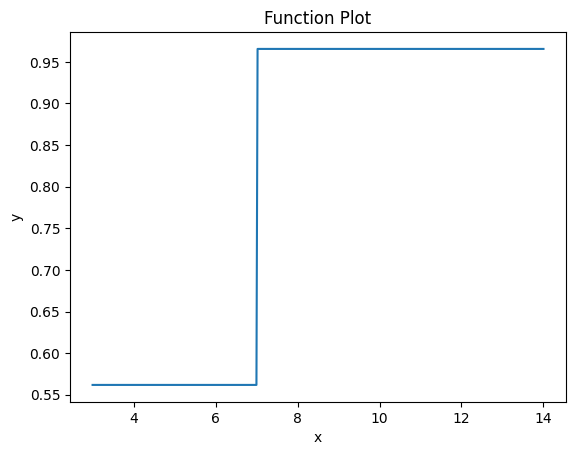

In [5]:
x = np.linspace(time_steps[0], time_steps[-1], 400)

y = [eps_func(x_i) for x_i in x]

plt.plot(x, y)

plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

INFO: Preparing data for visualization...
INFO: UMAP model provided. Transforming high-dimensional data to 2D...


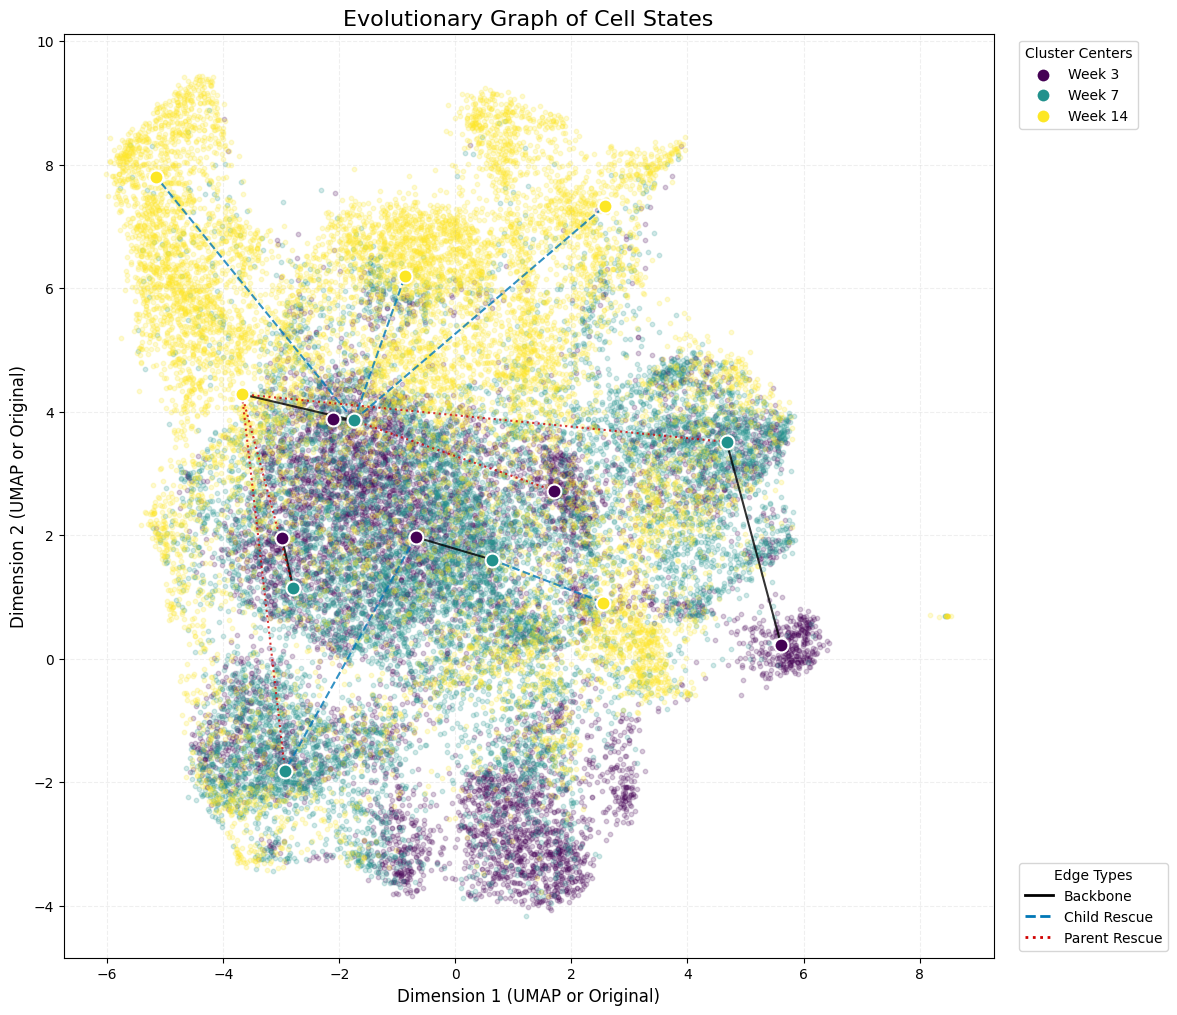

In [6]:
all_points_map, msf_edges = pm.calculate_evolutionary_graph([c.cpu().numpy() for c in cluster_centers], metric='euclidean')
vi.visualize_full_evolution(
    raw_data=[d.cpu().numpy() for d in data_lst],
    centers=[c.cpu().numpy() for c in cluster_centers],
    all_points_map=all_points_map,
    edges=msf_edges,
    umap_model=reducer,
    time_labels=['Week ' + str(t) for t in time_steps]
)

Re-indexing nodes to continuous integers...
Graph simplification and re-indexing complete.
INFO: Preparing data for visualization...
INFO: UMAP model provided. Transforming high-dimensional data to 2D...


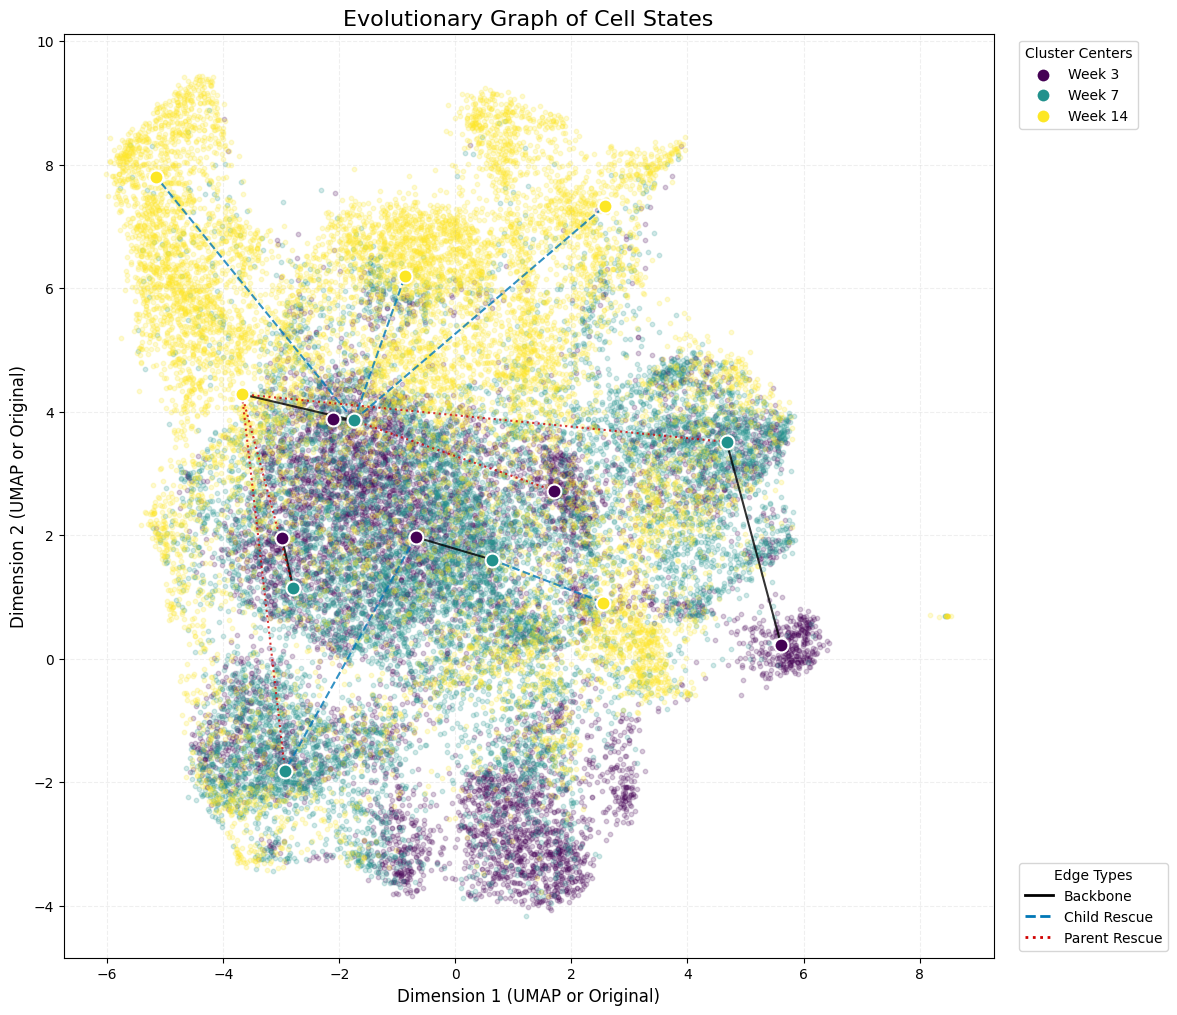

In [7]:
label_list_for_train = [cl.assign_labels(d.cuda(),cluster_centers[i].cuda()) for i, d in enumerate(data_lst)]
populations_map = cmp.count_cluster_samples(label_list_for_train)

all_points_map, cluster_centers, msf_edges = pm.simplify_evolutionary_graph(all_points_map, populations_map, msf_edges, epsilon_merge=10, theta_topo=0.5, metric='euclidean')
vi.visualize_full_evolution(
    raw_data=[d.cpu().numpy() for d in data_lst],
    centers=cluster_centers,
    all_points_map=all_points_map,
    edges=msf_edges,
    umap_model=reducer,
    time_labels=['Week ' + str(t) for t in time_steps]
)
cluster_centers = [torch.from_numpy(c) for c in cluster_centers]

In [8]:
xu = reducer.transform(torch.concat(data_lst).numpy())

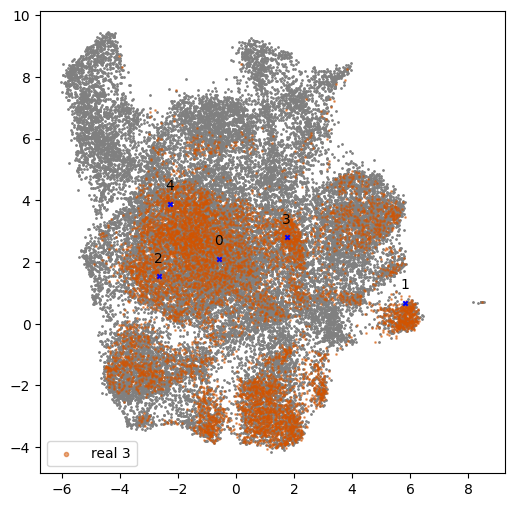

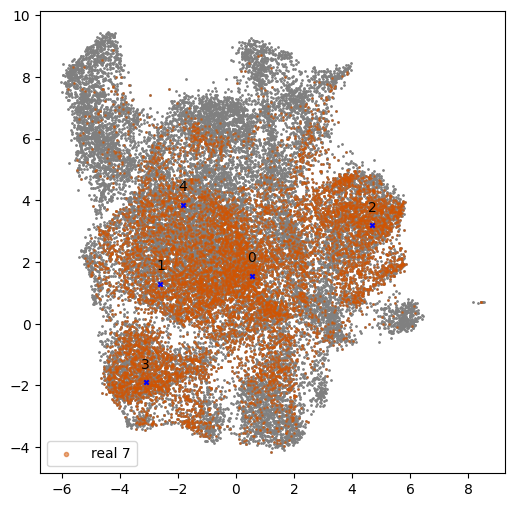

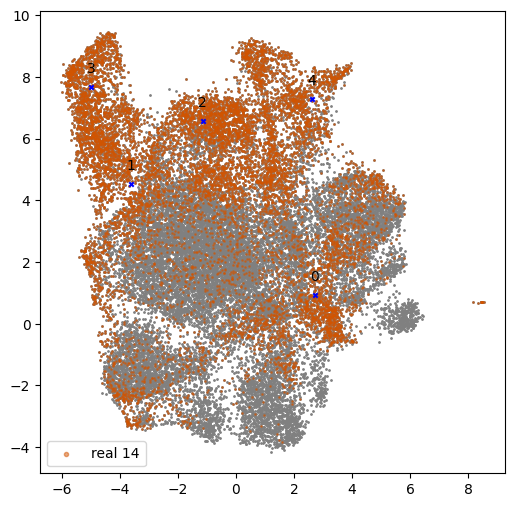

In [9]:
vi.visualize_populations(data_lst,time_steps,cluster_centers,umap_model=reducer,save_path='./CRISPR_results/raw_data')

In [10]:
import scope.datasets as ds

label_list_for_train = [cl.assign_labels(d.cuda(),cluster_centers[i].cuda()) for i, d in enumerate(data_lst)]

In [11]:
steps_each_day = 8
steps = 11*steps_each_day
# eps = lambda t: np.exp(0.1 * t) 
eps = eps_func
eps_test = eps
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=200,N_finetuning=200,backbone_lr=1e-3,finetuning_lr=1e-3,hiden_size=128,n_layers=4,
                              steps=steps,eps=eps,early_stop=True,patience=32,B=128,lambda_=0,save=True,record_gap=2,save_path='model_history/GSE222378',
                              prematched=True, label_list=label_list_for_train, edges=msf_edges, weighting_strategy='enos', beta=0.999)

INFO: 从演化图中找到了 12 条长度为 3 的有效路径（演化蓝图）。
defaultdict(<class 'float'>, {1: 0.3947863725043354, 3: 0.1474800211673589, 2: 0.17912476189518178, 4: 0.11145701985741278, 0: 0.16715182457571112})


processed: 200: 100%|██████████| 200/200 [16:24<00:00,  4.92s/it, loss=303.3068600658296, loss_fore=311.296790361117, loss_back=295.31692977054183]   


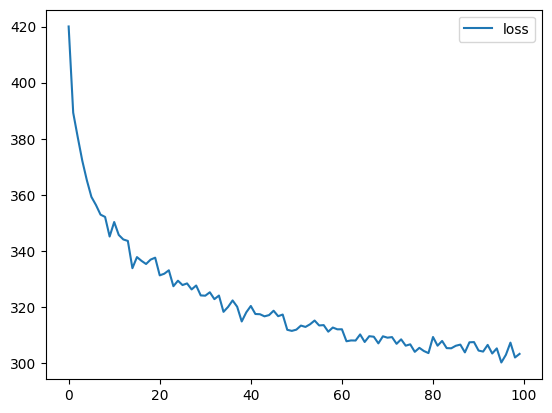

In [12]:
sb_object.backbone_train()
fore_base=sb_object.eval_fore(data_lst[0].cuda().double(),sb_object.v_fore)

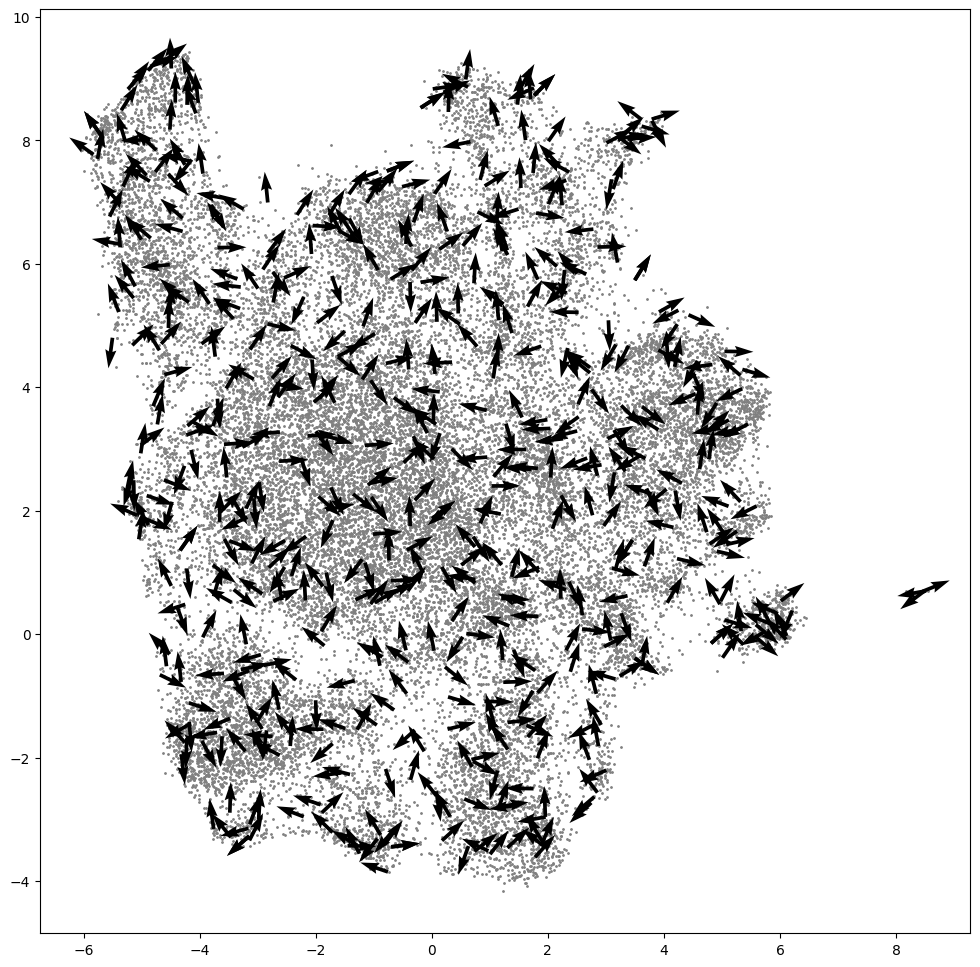

In [13]:
vi.visualize_drift_func([d.cuda() for d in data_lst],np.concatenate(data_lst),sb_object,meta,umap_model=reducer,save_path='./CRISPR_results/drift_backbone',xg_lower_bound=-10,xg_upper_bound=10,yg_lower_bound=-10,yg_upper_bound=10)

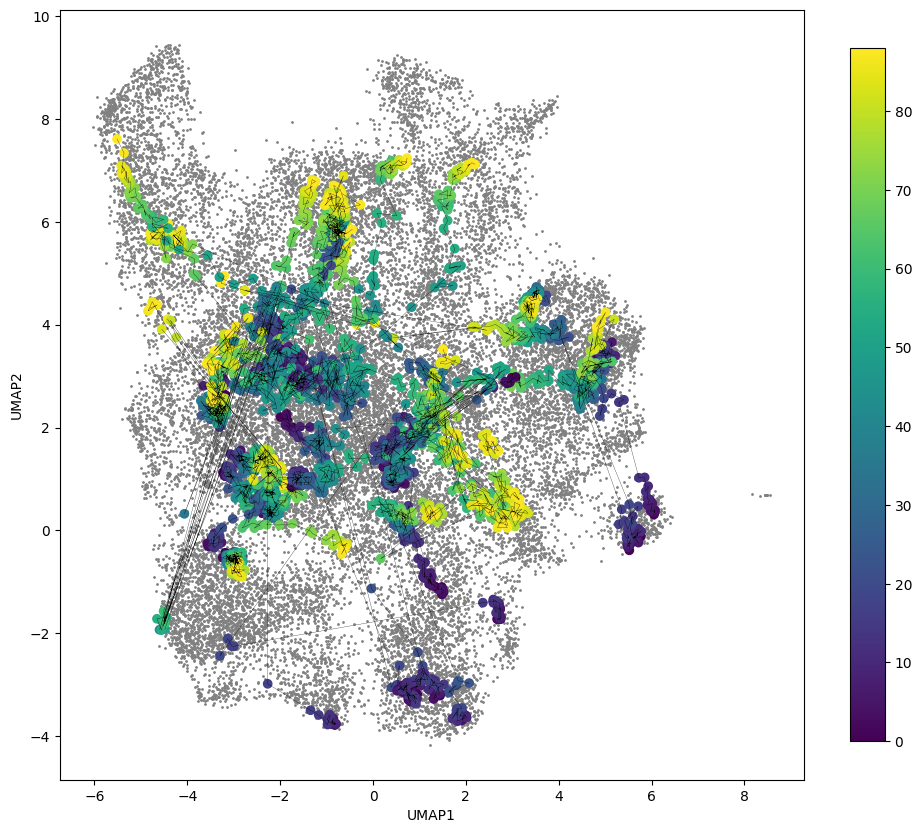

In [14]:
vi.visualize_generated_trajectories(data_lst,fore_base,umap_model=reducer,save_path='./CRISPR_results/generated_trajectories_backbone')

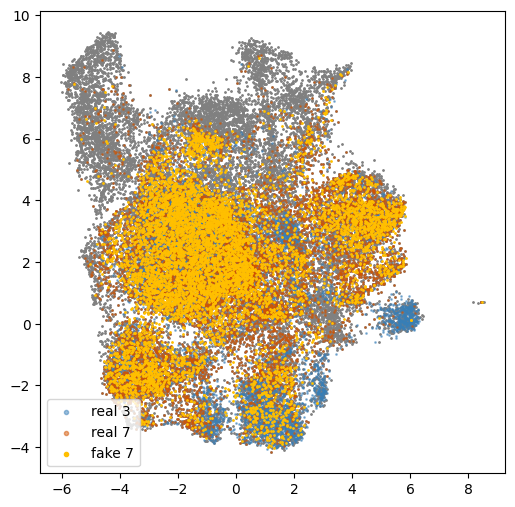

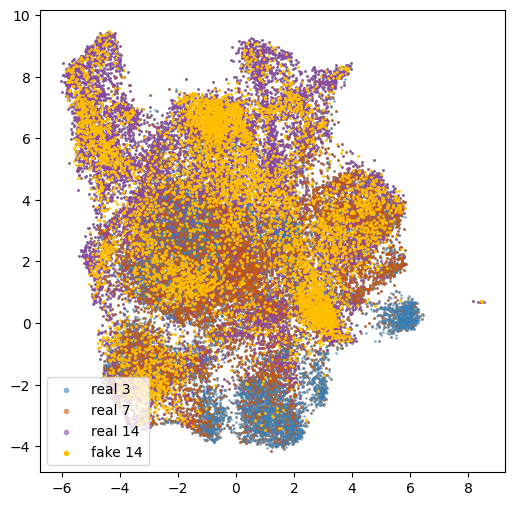

In [15]:
vi.visualize_generated_populations(data_lst,fore_base,time_steps,umap_model=reducer,save_path='./CRISPR_results/generated_populations_backbone')

processed: 200: 100%|██████████| 200/200 [1:57:06<00:00, 35.13s/it, loss=70.45217973361011, loss_back=70.45217973361011]


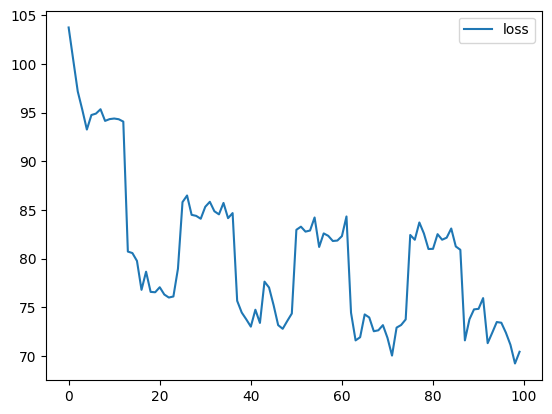

In [16]:
sb_object.fine_tune(change=25)
fore_ft=sb_object.eval_fore(data_lst[0].double(),sb_object.v_fore_fine_tuned)

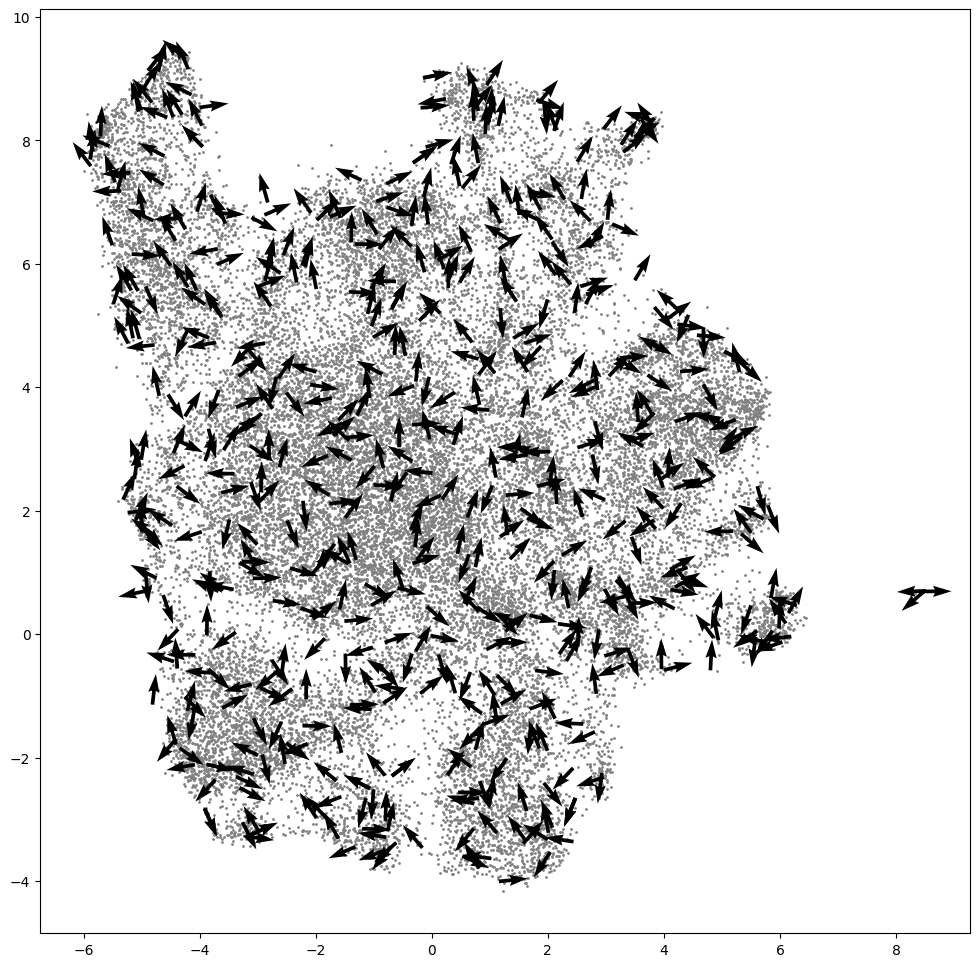

In [24]:
vi.visualize_drift_func(data_lst,np.concatenate(data_lst),sb_object,meta,umap_model=reducer,save_path='./CRISPR_results/drift_fine_tuned',fine_tuned=True,xg_lower_bound=-10,xg_upper_bound=10,yg_lower_bound=-10,yg_upper_bound=10)

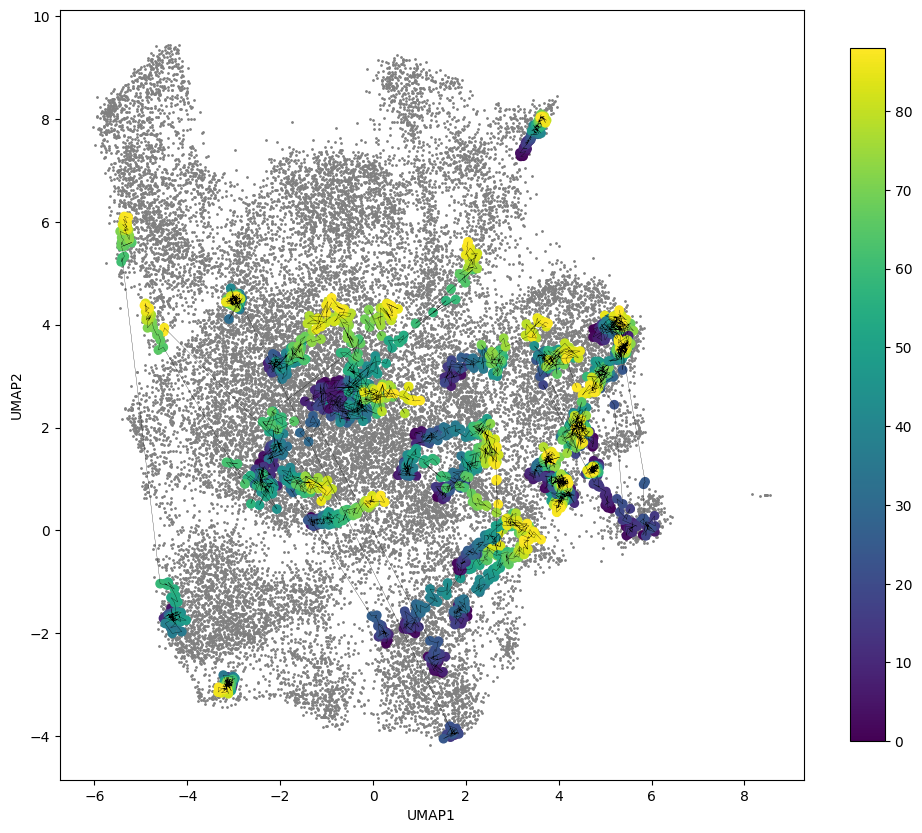

In [25]:
vi.visualize_generated_trajectories(data_lst,fore_ft,umap_model=reducer,save_path='./CRISPR_results/generated_trajectories_fine_tuned')

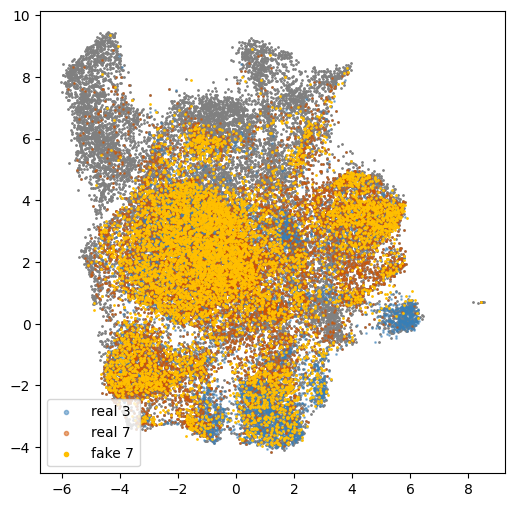

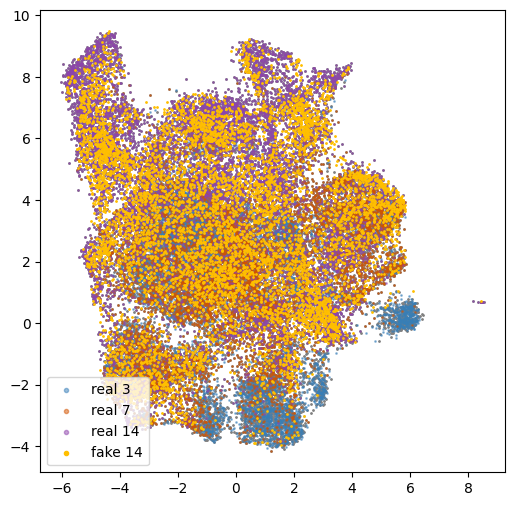

In [26]:
vi.visualize_generated_populations(data_lst,fore_ft,time_steps,umap_model=reducer,save_path='./CRISPR_results/generated_populations_fine_tuned')

In [35]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- a. 定义分析参数 ---
conditions_to_analyze = ['gLuc', 'Bcl11b', 'Spi1']
genes_for_plotting = ['Bcl11b', 'Stat1', 'Nfkb1', 'Spi1', 'Myc', 'Ets1']
existing_genes = [g for g in genes_for_plotting if g in adata.var_names]
num_runs = 1000
print(f"--- 分析方案: 比较 {conditions_to_analyze} 作为起点的细胞演化路径 ---")

# --- b. 为每种细胞类型独立进行批量模拟 ---
predicted_paths = {}

def run_simulation_batch(start_expression_matrix, pca_model, sb_object):
    # (此函数与之前完全相同，为了简洁此处省略其内部代码)
    start_pca_batch = pca_model.transform(start_expression_matrix)
    path_pca_list = sb_object.eval_fore(torch.from_numpy(start_pca_batch).double(), sb_object.v_fore_fine_tuned)
    path_pca_tensor = np.stack(path_pca_list, axis=0)
    n_steps, n_runs, n_components = path_pca_tensor.shape
    path_pca_reshaped = path_pca_tensor.reshape(-1, n_components)
    path_gene_space_reshaped = pca_model.inverse_transform(path_pca_reshaped)
    path_gene_space_tensor = path_gene_space_reshaped.reshape(n_steps, n_runs, -1)
    return path_gene_space_tensor

for condition in conditions_to_analyze:
    print(f"\n--- 正在为 '{condition}' 起点细胞进行模拟 ---")
    possible_start_cells = adata[(adata.obs['CRISPRgene'] == condition) & (adata.obs['timepoint'] == 'TP1'), :]
    if len(possible_start_cells) == 0: continue
    current_runs = min(num_runs, len(possible_start_cells))
    random_indices = np.random.choice(possible_start_cells.obs.index, size=current_runs, replace=False)
    start_cells_expression = adata[random_indices, :].X.toarray()
    predicted_paths[condition] = run_simulation_batch(start_cells_expression, pca_model, sb_object)

print("\n--- 所有模拟完成 ---")

--- 分析方案: 比较 ['gLuc', 'Bcl11b', 'Spi1'] 作为起点的细胞演化路径 ---

--- 正在为 'gLuc' 起点细胞进行模拟 ---

--- 正在为 'Bcl11b' 起点细胞进行模拟 ---

--- 正在为 'Spi1' 起点细胞进行模拟 ---

--- 所有模拟完成 ---


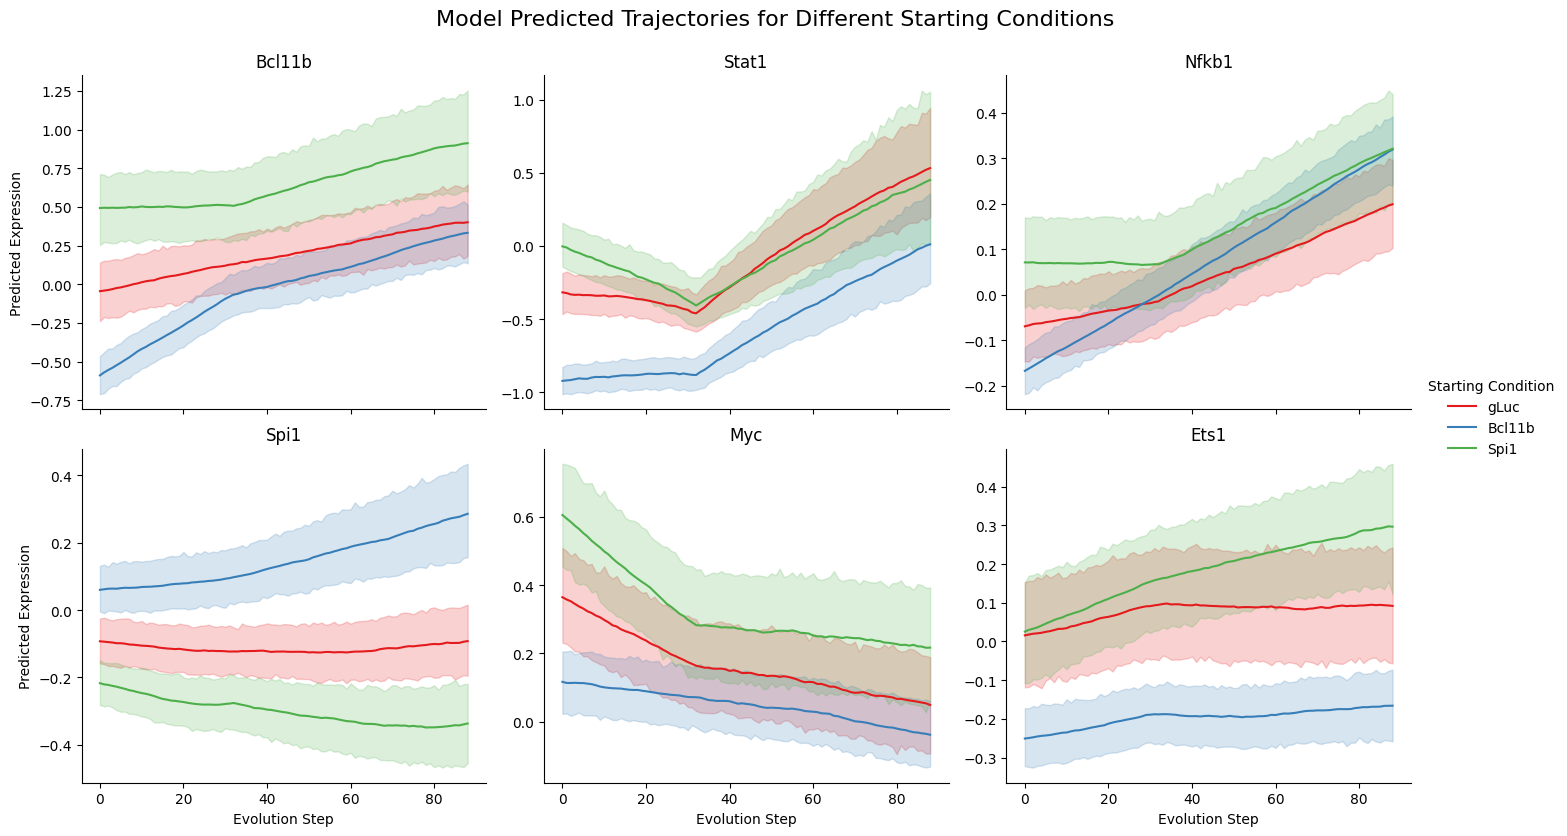

In [38]:
all_predicted_data = []
n_steps = list(predicted_paths.values())[0].shape[0]
gene_indices = [adata.var_names.get_loc(g) for g in existing_genes]

for condition, tensor in predicted_paths.items():
    current_runs = tensor.shape[1]
    path_genes = tensor[:, :, gene_indices].reshape(-1, len(existing_genes))
    df = pd.DataFrame(path_genes, columns=existing_genes)
    df['Evolution Step'] = np.repeat(range(n_steps), current_runs)
    df['Starting Condition'] = condition
    all_predicted_data.append(df)

predicted_df = pd.concat(all_predicted_data, ignore_index=True)
predicted_long_df = pd.melt(predicted_df, id_vars=['Evolution Step', 'Starting Condition'], 
                            value_vars=existing_genes, var_name='Gene', value_name='Predicted Expression')


g1 = sns.relplot(
    data=predicted_long_df,
    x='Evolution Step',
    y='Predicted Expression',
    hue='Starting Condition',
    col='Gene',
    kind='line',
    col_wrap=3,
    palette="Set1",
    height=4,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g1.fig.suptitle('Model Predicted Trajectories for Different Starting Conditions', y=1.04, fontsize=16)
g1.set_titles(col_template="{col_name}", size=12)
plt.savefig("./CRISPR_results/Predicted_Trajectories.svg", dpi=1200, bbox_inches='tight')
plt.show()

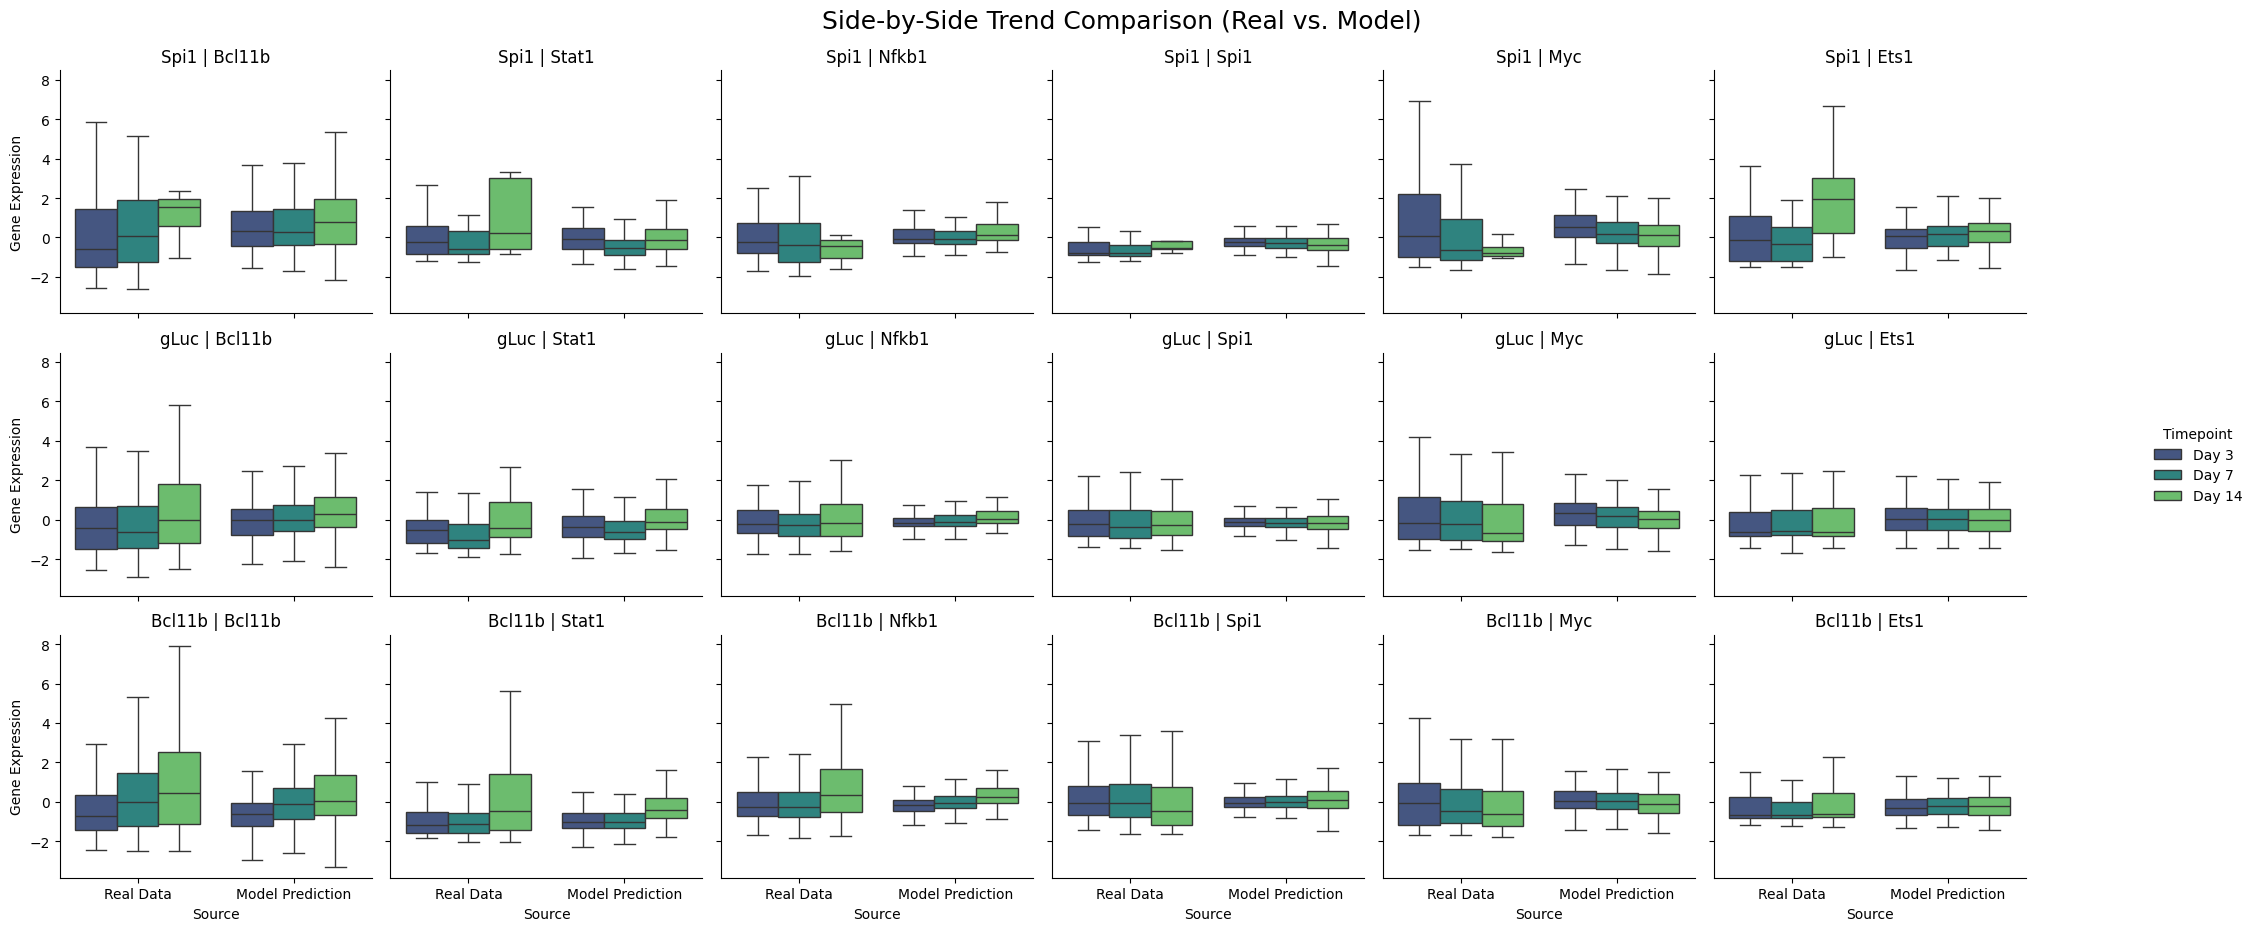

In [39]:

n_steps = len(fore_ft)
step_each_day = (n_steps -1) / 11 


model_steps_to_extract = {
    'TP1': 0, 
    'TP2': int(4 * step_each_day),
    'TP3': n_steps - 1
}
point_dic = {'TP1':'Day 3','TP2':'Day 7','TP3':'Day 14'}

model_comparison_data = []
gene_indices = [adata.var_names.get_loc(g) for g in existing_genes]
for condition, tensor in predicted_paths.items():
    for timepoint, step in model_steps_to_extract.items():
        step_data = tensor[step, :, :][:, gene_indices]
        df = pd.DataFrame(step_data, columns=existing_genes)
        df['Timepoint'] = timepoint
        df['Condition'] = condition
        df['Source'] = 'Model Prediction'
        model_comparison_data.append(df)
model_df = pd.concat(model_comparison_data)
model_df['Timepoint'] = model_df['Timepoint'].apply(lambda x: point_dic[x]).values
real_data_subset = adata[adata.obs['CRISPRgene'].isin(conditions_to_analyze), existing_genes]
real_df = real_data_subset.to_df()

real_df['Timepoint'] = real_data_subset.obs['timepoint'].apply(lambda x: point_dic[x]).values
real_df['Condition'] = real_data_subset.obs['CRISPRgene'].values
real_df['Source'] = 'Real Data'
comparison_df = pd.concat([real_df, model_df])
comparison_long_df = pd.melt(comparison_df, id_vars=['Timepoint', 'Condition', 'Source'],
                             value_vars=existing_genes, var_name='Gene', value_name='Expression')

g = sns.catplot(
    data=comparison_long_df,
    x='Source',
    y='Expression',
    hue='Timepoint',
    col='Gene',
    row='Condition',
    kind='box',
    hue_order=['Day 3', 'Day 7', 'Day 14'],
    palette='viridis',
    showfliers=False,
    height=3,
    aspect=1.2,
    legend_out=True, 
    # facet_kws={'margin_titles': True}
)

g.fig.suptitle('Side-by-Side Trend Comparison (Real vs. Model)', y=1.03, fontsize=18)
g.set_titles(row_template="{row_name}", col_template="{col_name}", size=12)
g.set_axis_labels("Source", "Gene Expression")

plt.subplots_adjust(right=0.9)

g.legend.set_title("Timepoint")
plt.savefig("./CRISPR_results/Trend_Comparison.svg", dpi=1200, bbox_inches='tight')
plt.show()
